In [254]:
#import all the relevant libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yf
import talib as ta

np.set_printoptions(precision = 3)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

import warnings
warnings.filterwarnings("ignore")

from collections import defaultdict

In [ ]:
# df = pd.read_csv('btcusd_1-min_data.csv')

all_data1 = pd.read_csv("./datasets/btcusd_1-min_data.csv")
df = pd.DataFrame(all_data1)

# Convert Timestamp to datetime
df['Datetime'] = pd.to_datetime(df['Timestamp'], unit='s')

# Optional: Set as indexx
df.set_index('Datetime', inplace=True)

# Assuming 'df' is already indexed by datetime
df_5min = df.resample('5min').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).dropna()

df_5min

,Open,High,Low,Close,Volume
Datetime,,,,,
2012-01-01 10:00:00,4.58,4.58,4.58,4.58,0.000000
2012-01-01 10:05:00,4.58,4.58,4.58,4.58,0.000000
2012-01-01 10:10:00,4.58,4.58,4.58,4.58,0.000000
2012-01-01 10:15:00,4.58,4.58,4.58,4.58,0.000000
2012-01-01 10:20:00,4.58,4.58,4.58,4.58,0.000000
...,...,...,...,...,...
2025-06-11 00:25:00,109865.00,109955.00,109841.00,109897.00,0.030716
2025-06-11 00:30:00,109859.00,109874.00,109845.00,109872.00,0.291974
2025-06-11 00:35:00,109950.00,110068.00,109930.00,109986.00,4.474345


In [256]:
# select back test horizon
PriceDF = df_5min[1200000:]
PriceDF
# PriceDF.to_excel("price_data.xlsx", index=False)

,Open,High,Low,Close,Volume
Datetime,,,,,
2023-05-30 02:00:00,27676.0,27676.0,27598.0,27629.0,5.018327
2023-05-30 02:05:00,27626.0,27645.0,27622.0,27645.0,0.636814
2023-05-30 02:10:00,27648.0,27650.0,27621.0,27622.0,2.451645
2023-05-30 02:15:00,27623.0,27631.0,27580.0,27585.0,23.983854
2023-05-30 02:20:00,27580.0,27611.0,27580.0,27611.0,1.298105
...,...,...,...,...,...
2025-06-11 00:25:00,109865.0,109955.0,109841.0,109897.0,0.030716
2025-06-11 00:30:00,109859.0,109874.0,109845.0,109872.0,0.291974
2025-06-11 00:35:00,109950.0,110068.0,109930.0,109986.0,4.474345


In [257]:
#signals
ShortWindow = 5
LongWindow = 200

# Calculate 10-day and 50-day SMAs
def SMACrossoverSignal(PriceDF, ShortWindow, LongWindow):
    SignalDF = []
    PriceDF['SMAShortWindow'] = ta.SMA(PriceDF['Close'], timeperiod=ShortWindow)
    PriceDF['SMALongWindow'] = ta.SMA(PriceDF['Close'], timeperiod=LongWindow)
    SignalDF = PriceDF[['Open', 'High', 'Low', 'Close', 'SMAShortWindow', 'SMALongWindow']].iloc[LongWindow-1:]
    # SignalDF = SignalDF.rename(columns={'Close': 'Price'})
    return SignalDF

In [258]:
SMACrossoverSignal(PriceDF, ShortWindow, LongWindow)
SignalDF = SMACrossoverSignal(PriceDF, ShortWindow, LongWindow)

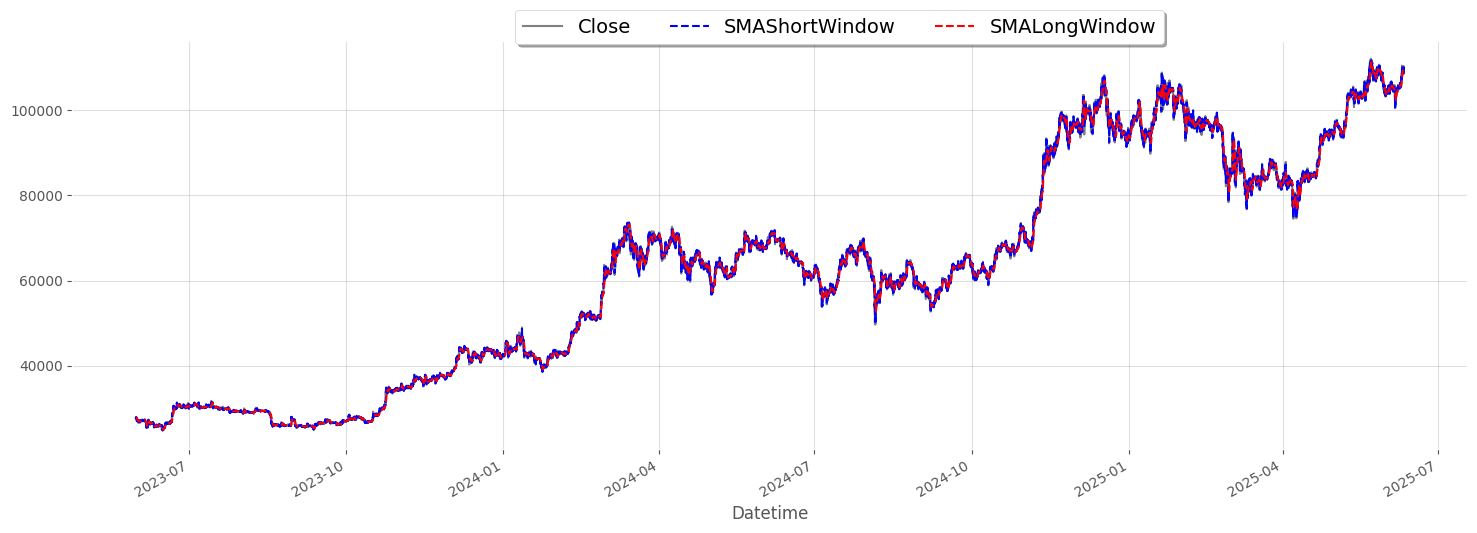

In [259]:
SMAPlot =\
(
    SignalDF
    [["Close", "SMAShortWindow", "SMALongWindow"]]
    .plot(color = ["grey", "blue", "red"],
          style = ["-", "--", "--"],
          figsize = [18, 6]
         )
)

(
    SMAPlot
    .legend(loc = "upper center",
            shadow = True,
            ncol = 4,
            bbox_to_anchor = (0.55, 1.10),
            fancybox = True)
)

In [302]:
SignalDF = SMACrossoverSignal(PriceDF, ShortWindow, LongWindow)

def SMACrossoverStrategyLongShort(SignalDF):
    TradingStrategy = pd.DataFrame(index = SignalDF.index)
    TradingStrategy["Action"] = 0
    TradingStrategy["Open"] = SignalDF['Open']
    TradingStrategy["High"] = SignalDF['High']
    TradingStrategy["Low"] = SignalDF['Low']
    TradingStrategy["Close"] = SignalDF['Close']
    TradingStrategy["SMAShortWindow"] = SignalDF['SMAShortWindow']
    TradingStrategy["SMALongWindow"] = SignalDF['SMALongWindow']
    TradingStrategy["SMADiff"] = TradingStrategy["SMAShortWindow"] - TradingStrategy["SMALongWindow"]

    # Calculate SMA first differences
    long_diff = TradingStrategy["SMALongWindow"].diff()
    TradingStrategy["LongDiff"] = long_diff.bfill()
    TradingStrategy["LongDiffSMA"] = TradingStrategy["LongDiff"].rolling(window=10).mean().bfill()

    # Detect inflections: sign of diff changes
    long_inflection_up = (TradingStrategy["LongDiffSMA"].shift(1) < 0) & (TradingStrategy["LongDiffSMA"] > 0)  # long SMA local minimum
    short_inflection_down = (TradingStrategy["LongDiffSMA"].shift(1) > 0) & (TradingStrategy["LongDiffSMA"] < 0)  # short SMA local maximum

    # Entry signals
    TradingStrategy["Positions"] = np.where(long_inflection_up, 1, np.nan)      # long signal
    TradingStrategy["Positions"] = np.where(short_inflection_down, -1, TradingStrategy["Positions"])  # short signal

    # Position exit
    TradingStrategy["Positions"] = TradingStrategy["Positions"].ffill()
    TradingStrategy["Positions"] = TradingStrategy["Positions"].fillna(0)
    TradingStrategy["Action"] = TradingStrategy["Positions"].diff()
    TradingStrategy["Action"][0] = 0
    TradingStrategy["Returns"] = np.log(TradingStrategy['Close'] / TradingStrategy['Close'].shift(1))
    TradingStrategy["Strategy"] = TradingStrategy["Returns"] * TradingStrategy["Positions"].shift(1)
    TradingStrategy["Returns"][0] = 0
    TradingStrategy["Strategy"][0] = 0
    log_cost = np.log(1 - 0.0001)
    TradingStrategy["Strategy_w_cost"] = TradingStrategy["Strategy"] + np.where(TradingStrategy["Action"] != 0, log_cost*abs(TradingStrategy["Action"]), 0)
    return TradingStrategy


In [303]:
SignalDF["SMAShortLongWindowDiff"] = SignalDF["SMAShortWindow"] - SignalDF["SMALongWindow"]
SignalDF["SMALongWindowDiff"] = SignalDF["SMALongWindow"].diff().bfill()
SignalDF["LongDiffSMA10"] = SignalDF["SMALongWindowDiff"].rolling(10).mean().bfill()
SignalDF["LongDiffSMA10_shift_1"] = SignalDF["LongDiffSMA10"].shift(1)

SignalDF["long_inflection_up"] = (SignalDF["LongDiffSMA10_shift_1"] < 0) & (SignalDF["LongDiffSMA10"] > 0) 
SignalDF["short_inflection_down"] = (SignalDF["LongDiffSMA10_shift_1"] > 0) & (SignalDF["LongDiffSMA10"] < 0)

SignalDF["Positions"] = np.where(SignalDF["long_inflection_up"], 1, np.nan)
SignalDF["Positions"] = np.where(SignalDF["short_inflection_down"], -1, SignalDF["Positions"])

SignalDF.head(30)



,Open,High,Low,Close,SMAShortWindow,SMALongWindow,SMAShortLongWindowDiff,SMALongWindowDiff,LongDiffSMA10,LongDiffSMA10_shift_1,long_inflection_up,short_inflection_down,Positions
Datetime,,,,,,,,,,,,,
2021-07-22 16:35:00,31934.46,32153.25,31917.96,32117.40,31908.568,31985.14510,-76.57710,2.78135,2.635075,NaN,False,False,NaN
2021-07-22 16:40:00,32093.46,32217.98,32062.28,32165.99,31971.440,31987.92645,-16.48645,2.78135,2.635075,2.635075,False,False,NaN
2021-07-22 16:45:00,32165.59,32165.62,32069.86,32095.94,32025.866,31989.95550,35.91050,2.02905,2.635075,2.635075,False,False,NaN
2021-07-22 16:50:00,32087.44,32131.22,32077.69,32095.04,32084.050,31992.34750,91.70250,2.39200,2.635075,2.635075,False,False,NaN
2021-07-22 16:55:00,32096.66,32216.16,32093.34,32213.30,32137.534,31994.95765,142.57635,2.61015,2.635075,2.635075,False,False,NaN
2021-07-22 17:00:00,32191.33,32254.92,32138.65,32173.59,32148.772,31997.25910,151.51290,2.30145,2.635075,2.635075,False,False,NaN
2021-07-22 17:05:00,32160.54,32220.86,32152.75,32186.16,32152.806,32000.18165,152.62435,2.92255,2.635075,2.635075,False,False,NaN
2021-07-22 17:10:00,32177.90,32253.77,32168.62,32200.66,32173.750,32003.12950,170.62050,2.94785,2.635075,2.635075,False,False,NaN
2021-07-22 17:15:00,32185.91,32206.72,32150.93,32168.74,32188.490,32006.26890,182.22110,3.13940,2.635075,2.635075,False,False,NaN


In [262]:
SMACrossoverStrategyLongShort(SignalDF)
TradingStrategy = SMACrossoverStrategyLongShort(SignalDF)

In [263]:
TradingStrategy

,Action,Open,High,Low,Close,SMAShortWindow,SMALongWindow,SMADiff,LongDiff,LongDiffSMA,Positions,Returns,Strategy,Strategy_w_cost
Datetime,,,,,,,,,,,,,,
2023-05-30 18:35:00,0.0,27760.0,27785.0,27759.0,27773.0,27789.4,27815.130,-25.730,0.315,0.2575,0.0,0.000000,0.000000,0.000000
2023-05-30 18:40:00,0.0,27765.0,27765.0,27671.0,27692.0,27758.2,27815.445,-57.245,0.315,0.2575,0.0,-0.002921,-0.000000,0.000000
2023-05-30 18:45:00,0.0,27688.0,27724.0,27663.0,27718.0,27744.8,27815.810,-71.010,0.365,0.2575,0.0,0.000938,0.000000,0.000000
2023-05-30 18:50:00,0.0,27708.0,27733.0,27695.0,27695.0,27727.4,27816.175,-88.775,0.365,0.2575,0.0,-0.000830,-0.000000,0.000000
2023-05-30 18:55:00,0.0,27699.0,27704.0,27630.0,27630.0,27701.6,27816.400,-114.800,0.225,0.2575,0.0,-0.002350,-0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-11 00:25:00,0.0,109865.0,109955.0,109841.0,109897.0,109980.2,109416.370,563.830,3.285,3.6675,1.0,0.000291,0.000291,0.000291
2025-06-11 00:30:00,0.0,109859.0,109874.0,109845.0,109872.0,109927.4,109419.185,508.215,2.815,3.5935,1.0,-0.000228,-0.000228,-0.000228
2025-06-11 00:35:00,0.0,109950.0,110068.0,109930.0,109986.0,109924.0,109422.785,501.215,3.600,3.5755,1.0,0.001037,0.001037,0.001037


In [264]:
def df_equity_curve(TradingStrategy):
    # Compute equity curves
    TradingStrategy["EquityStrategy"] = np.exp(TradingStrategy["Strategy"].cumsum())
    TradingStrategy["EquityStrategy_w_cost"] = np.exp(TradingStrategy["Strategy_w_cost"].cumsum())
    TradingStrategy["EquityBuyHold"] = np.exp(TradingStrategy["Returns"].cumsum())
    return TradingStrategy

<Axes: xlabel='Datetime'>

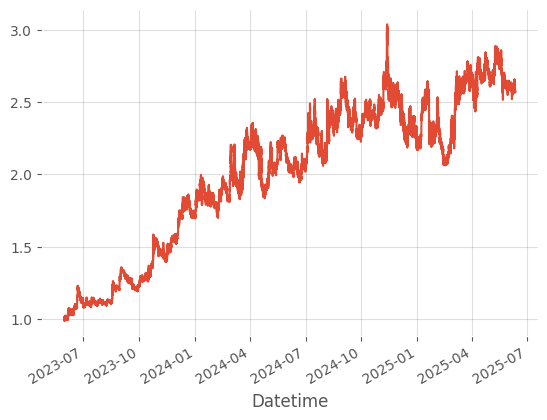

In [265]:
df_equity_curve(TradingStrategy)['EquityStrategy'].plot()

<Axes: xlabel='Datetime'>

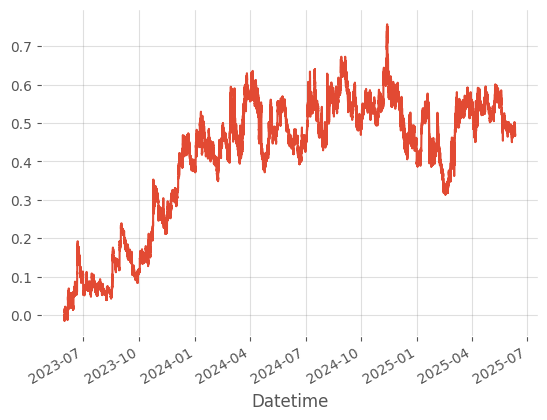

In [266]:
TradingStrategy.Strategy_w_cost.cumsum().plot()

In [267]:
non_zero_count = (TradingStrategy['Action'] != 0).sum()
non_zero_count

np.int64(2382)

In [268]:
# check number of trades
print(TradingStrategy["Action"].value_counts())

Action
 0.0    211158
 2.0      1191
-2.0      1190
-1.0         1
Name: count, dtype: int64


In [269]:
(2311 * 2 + 2311 *2 + 1)

9245

In [270]:
9245 * 0.0002

1.8490000000000002

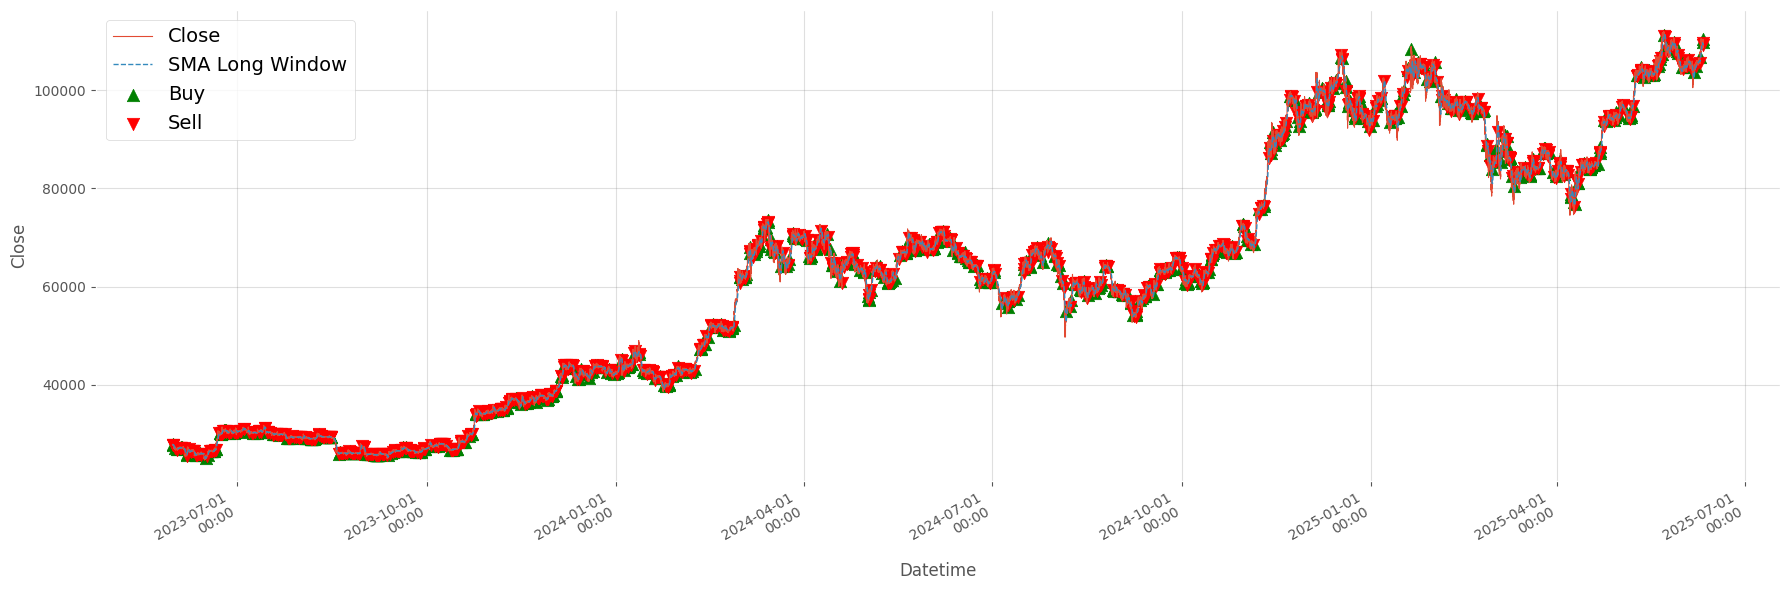

In [271]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(18, 6))

# Price line
ax.plot(TradingStrategy.index,
        TradingStrategy['Close'],
        linewidth=0.8,
        label='Close')

# Long SMA line
ax.plot(TradingStrategy.index,
        TradingStrategy['SMALongWindow'],
        linestyle='--', linewidth=1.0, label='SMA Long Window')

# Buy signals
buys = TradingStrategy.loc[TradingStrategy.Action >= 1.0]
ax.scatter(buys.index, buys['Close'],
           marker='^', color='green', s=80, label='Buy')

# Sell signals
sells = TradingStrategy.loc[TradingStrategy.Action <= -1.0]
ax.scatter(sells.index, sells['Close'],
           marker='v', color='red', s=80, label='Sell')

# Format x-axis
ax.set_xlabel('Datetime')
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
fig.autofmt_xdate()

ax.set_ylabel('Close')
ax.legend()
plt.tight_layout()
plt.show()

In [272]:
def ConvertToDailyReturns(TradingStrategy):
    daily_log_returns = TradingStrategy['Returns'].groupby(TradingStrategy.index.date).sum()
    daily_log_returns = pd.Series(daily_log_returns, name='DailyLogReturn')
    daily_log_returns.index = pd.to_datetime(daily_log_returns.index)
    daily_log_strategy = TradingStrategy['Strategy'].groupby(TradingStrategy.index.date).sum()
    daily_log_strategy = pd.Series(daily_log_strategy, name='DailyLogStrategy')
    daily_log_strategy.index = pd.to_datetime(daily_log_strategy.index)
    daily_log_strategy_w_cost = TradingStrategy['Strategy_w_cost'].groupby(TradingStrategy.index.date).sum()
    daily_log_strategy_w_cost = pd.Series(daily_log_strategy_w_cost, name='DailyLogStrategywCost')
    daily_log_strategy_w_cost.index = pd.to_datetime(daily_log_strategy_w_cost.index)
    DailyStrategy = pd.DataFrame(daily_log_strategy)
    DailyStrategy['DailyLogReturn'] = daily_log_returns
    DailyStrategy['DailyLogStrategywCost'] = daily_log_strategy_w_cost
    return DailyStrategy

In [273]:
import matplotlib.pyplot as plt
import numpy as np

def plot_equity_curve(DailyStrategy):
    # Compute equity curves
    initial_capital = 1
    DailyStrategy["EquityStrategy"] = np.exp(DailyStrategy["DailyLogStrategy"]) - 1
    DailyStrategy["EquityStrategyCap"] = (1 + DailyStrategy["EquityStrategy"]).cumprod() * initial_capital 
    DailyStrategy["EquityStrategy_w_cost"] = np.exp(DailyStrategy["DailyLogStrategywCost"]) - 1
    DailyStrategy["EquityStrategyCap_w_cost"] = (1 + DailyStrategy["EquityStrategy_w_cost"]).cumprod() * initial_capital
    DailyStrategy["EquityBuyHold"] = np.exp(DailyStrategy["DailyLogReturn"]) -1
    DailyStrategy["EquityBuyHoldCap"] = (1 + DailyStrategy["EquityBuyHold"]).cumprod() * initial_capital
    

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(DailyStrategy.index, DailyStrategy["EquityStrategyCap"], label="Strategy")
    plt.plot(DailyStrategy.index, DailyStrategy["EquityStrategyCap_w_cost"], label="Strategy (w/ cost)")
    plt.plot(DailyStrategy.index, DailyStrategy["EquityBuyHoldCap"], label="Buy & Hold")
    plt.title("Equity Curve")
    plt.xlabel("Date")
    plt.ylabel("Equity (Growth of $1)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

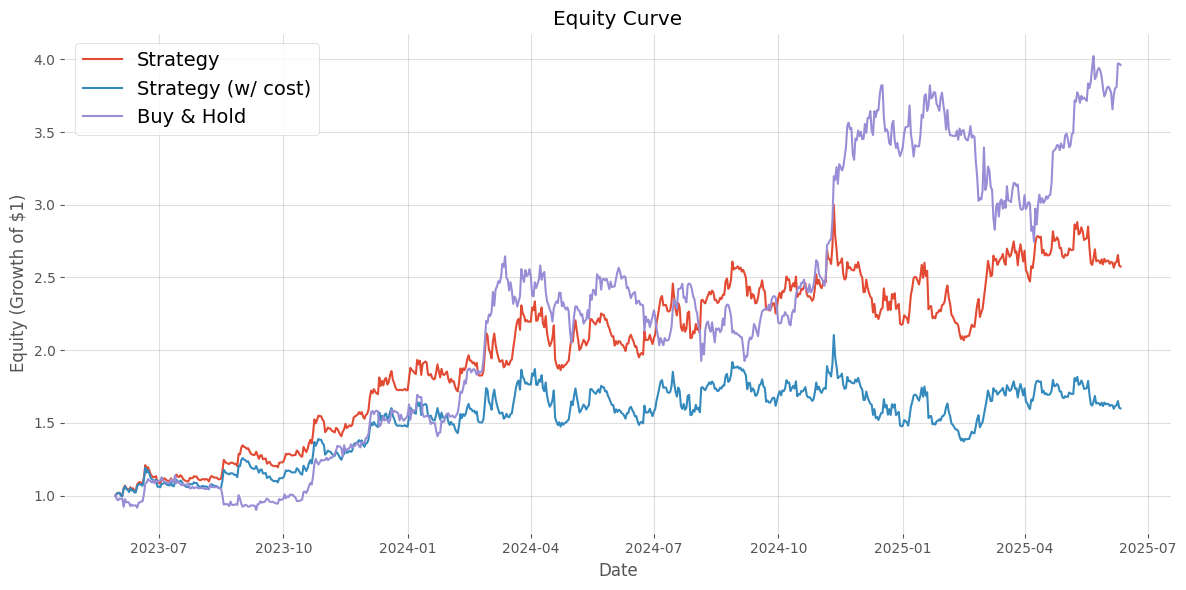

In [274]:
DailyStrategy = ConvertToDailyReturns(TradingStrategy)
plot_equity_curve(DailyStrategy)

In [275]:
import matplotlib.pyplot as plt
import numpy as np

def plot_equity_curve(DailyStrategy):
    # Compute equity curves
    DailyStrategy["EquityStrategy"] = np.exp(DailyStrategy["DailyLogStrategy"].cumsum())
    DailyStrategy["EquityStrategy_w_cost"] = np.exp(DailyStrategy["DailyLogStrategywCost"].cumsum())
    DailyStrategy["EquityBuyHold"] = np.exp(DailyStrategy["DailyLogReturn"].cumsum())

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(DailyStrategy.index, DailyStrategy["EquityStrategy"], label="Strategy")
    plt.plot(DailyStrategy.index, DailyStrategy["EquityStrategy_w_cost"], label="Strategy (w/ cost)")
    plt.plot(DailyStrategy.index, DailyStrategy["EquityBuyHold"], label="Buy & Hold")
    plt.title("Equity Curve")
    plt.xlabel("Date")
    plt.ylabel("Equity (Growth of $1)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

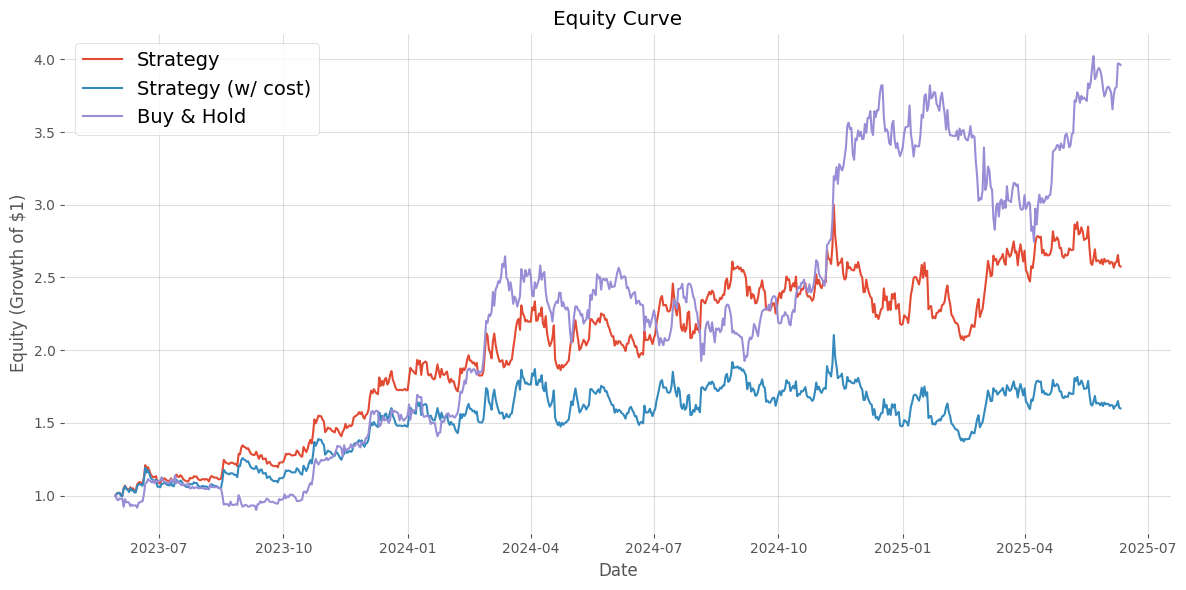

In [276]:
DailyStrategy = ConvertToDailyReturns(TradingStrategy)
plot_equity_curve(DailyStrategy)

In [277]:
def df_equity_curve(DailyStrategy):
    # Compute equity curves
    DailyStrategy["EquityStrategy"] = np.exp(DailyStrategy["DailyLogStrategy"].cumsum())
    DailyStrategy["EquityStrategy_w_cost"] = np.exp(DailyStrategy["DailyLogStrategywCost"].cumsum())
    DailyStrategy["EquityBuyHold"] = np.exp(DailyStrategy["DailyLogReturn"].cumsum())
    return DailyStrategy

In [278]:
DailyStrategy = ConvertToDailyReturns(TradingStrategy)
df_equity_curve(DailyStrategy)

,DailyLogStrategy,DailyLogReturn,DailyLogStrategywCost,EquityStrategy,EquityStrategy_w_cost,EquityBuyHold
2023-05-30,-0.002134,0.003164,-0.002434,0.997868,0.997569,1.003169
2023-05-31,0.017117,-0.030651,0.016517,1.015096,1.014183,0.972887
2023-06-01,0.002442,-0.005679,0.001842,1.017578,1.016053,0.967378
2023-06-02,0.002211,0.013824,0.001811,1.019830,1.017894,0.980845
2023-06-03,-0.017715,-0.004857,-0.019115,1.001924,0.998623,0.976092
...,...,...,...,...,...,...
2025-06-07,0.013257,0.011676,0.012857,2.601250,1.617479,3.802938
2025-06-08,0.001637,0.001637,0.001637,2.605511,1.620128,3.809167
2025-06-09,0.018670,0.041792,0.018270,2.654612,1.649999,3.971735
2025-06-10,-0.028075,-0.000136,-0.028875,2.581120,1.603036,3.971195


In [279]:
DailyStrategy

,DailyLogStrategy,DailyLogReturn,DailyLogStrategywCost,EquityStrategy,EquityStrategy_w_cost,EquityBuyHold
2023-05-30,-0.002134,0.003164,-0.002434,0.997868,0.997569,1.003169
2023-05-31,0.017117,-0.030651,0.016517,1.015096,1.014183,0.972887
2023-06-01,0.002442,-0.005679,0.001842,1.017578,1.016053,0.967378
2023-06-02,0.002211,0.013824,0.001811,1.019830,1.017894,0.980845
2023-06-03,-0.017715,-0.004857,-0.019115,1.001924,0.998623,0.976092
...,...,...,...,...,...,...
2025-06-07,0.013257,0.011676,0.012857,2.601250,1.617479,3.802938
2025-06-08,0.001637,0.001637,0.001637,2.605511,1.620128,3.809167
2025-06-09,0.018670,0.041792,0.018270,2.654612,1.649999,3.971735
2025-06-10,-0.028075,-0.000136,-0.028875,2.581120,1.603036,3.971195


In [280]:
DailyStrategy = ConvertToDailyReturns(TradingStrategy)
DailyStrategy

,DailyLogStrategy,DailyLogReturn,DailyLogStrategywCost
2023-05-30,-0.002134,0.003164,-0.002434
2023-05-31,0.017117,-0.030651,0.016517
2023-06-01,0.002442,-0.005679,0.001842
2023-06-02,0.002211,0.013824,0.001811
2023-06-03,-0.017715,-0.004857,-0.019115
...,...,...,...
2025-06-07,0.013257,0.011676,0.012857
2025-06-08,0.001637,0.001637,0.001637
2025-06-09,0.018670,0.041792,0.018270
2025-06-10,-0.028075,-0.000136,-0.028875


In [281]:
# 5% one-sided VaR (left-tail)
rolling_var_5 = DailyStrategy["DailyLogStrategy"].rolling(window=50).quantile(0.05)
DailyStrategy["RollingVaR_5"] = DailyStrategy["DailyLogStrategy"].rolling(window=50).quantile(0.05)

<Axes: >

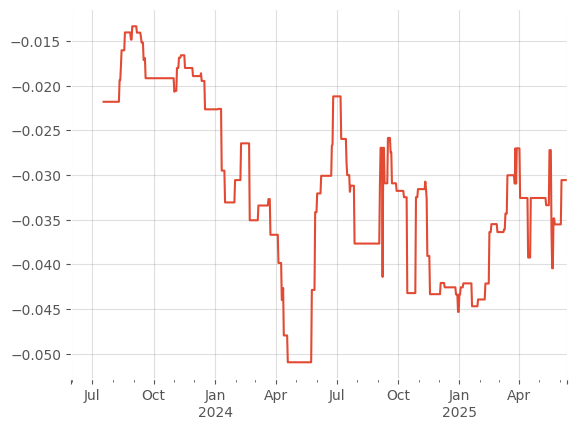

In [282]:
DailyStrategy["RollingVaR_5"].plot()

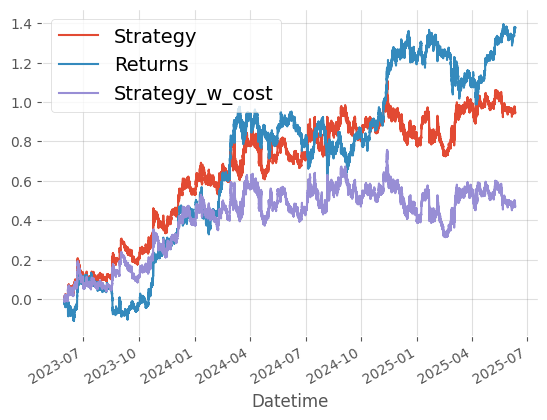

In [283]:
TradingStrategy.Strategy.cumsum().plot()
TradingStrategy.Returns.cumsum().plot()
TradingStrategy.Strategy_w_cost.cumsum().plot()
plt.legend()

In [284]:
import pandas as pd
import numpy as np

def top_drawdowns(df, log_return_col="DailyLogStrategywCost", top_n=5):
    # Step 1: Compute equity curve
    equity = np.exp(df[log_return_col].cumsum())

    # Step 2: Compute running max
    rolling_max = equity.cummax()

    # Step 3: Compute drawdown series
    drawdown = (equity - rolling_max) / rolling_max

    # Step 4: Identify drawdown periods
    in_drawdown = drawdown < 0
    drawdowns = []
    start = None

    for date, flag in in_drawdown.items():
        if flag:
            if start is None:
                start = date
        elif start is not None:
            end = date
            dd_slice = drawdown[start:end]
            min_drawdown = dd_slice.min()
            min_date = dd_slice.idxmin()
            drawdowns.append((min_drawdown, start, min_date, end))
            start = None

    # Handle case if still in drawdown at the end
    if start is not None:
        dd_slice = drawdown[start:]
        min_drawdown = dd_slice.min()
        min_date = dd_slice.idxmin()
        end = drawdown.index[-1]
        drawdowns.append((min_drawdown, start, min_date, end))

    # Sort by magnitude of drawdown
    top_drawdowns = sorted(drawdowns, key=lambda x: x[0])[:top_n]

    # Format output
    return pd.DataFrame(top_drawdowns, columns=["Drawdown", "Start", "Trough", "Recovery"])

In [285]:
top5_dd = top_drawdowns(DailyStrategy)
print(top5_dd)

   Drawdown      Start     Trough   Recovery
0 -0.348323 2024-11-12 2025-02-15 2025-06-11
1 -0.211539 2024-04-05 2024-04-23 2024-08-28
2 -0.156906 2024-08-29 2024-09-29 2024-11-11
3 -0.133257 2023-09-02 2023-09-27 2023-10-23
4 -0.130737 2024-01-09 2024-02-07 2024-02-28


<Axes: >

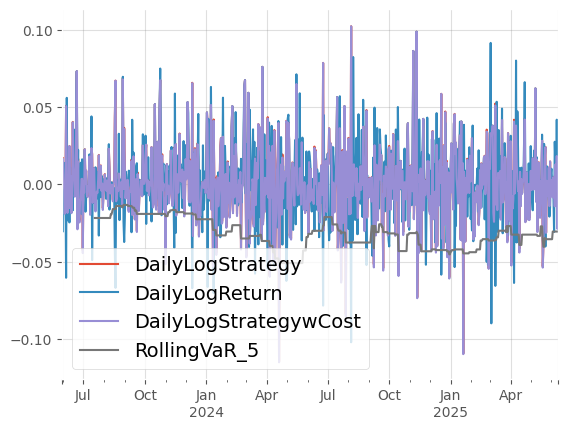

In [286]:
DailyStrategy.plot()

In [287]:
def CountTrades(TradingStrategy):
    # Filter only non-zero actions (i.e., actual trades)
    non_zero_trades = TradingStrategy[TradingStrategy['Action'] != 0]
    
    # Count number of trades per day
    daily_trade_count = non_zero_trades['Action'].groupby(non_zero_trades.index.date).count()
    
    return daily_trade_count

In [288]:
CountTrades(TradingStrategy)

2023-05-30    2
2023-05-31    3
2023-06-01    3
2023-06-02    2
2023-06-03    7
             ..
2025-06-05    4
2025-06-06    1
2025-06-07    2
2025-06-09    2
2025-06-10    4
Name: Action, Length: 666, dtype: int64

<Axes: >

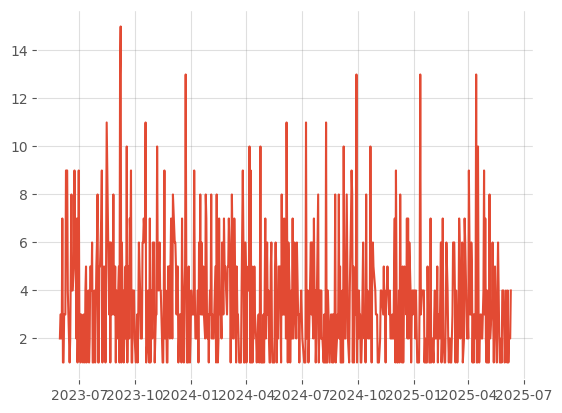

In [289]:
CountTrades(TradingStrategy).plot()

<Axes: xlabel='Datetime'>

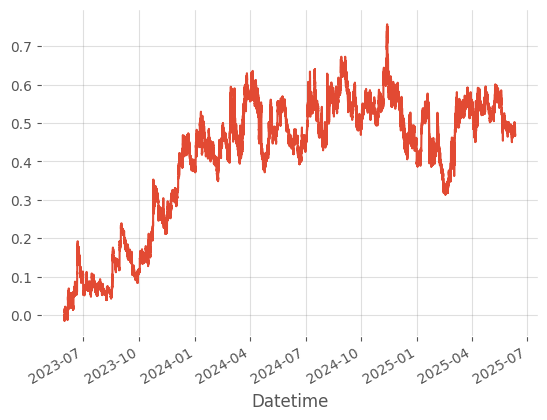

In [290]:
TradingStrategy.Strategy_w_cost.cumsum().plot()

In [291]:
DailyStrategy

,DailyLogStrategy,DailyLogReturn,DailyLogStrategywCost,RollingVaR_5
2023-05-30,-0.002134,0.003164,-0.002434,NaN
2023-05-31,0.017117,-0.030651,0.016517,NaN
2023-06-01,0.002442,-0.005679,0.001842,NaN
2023-06-02,0.002211,0.013824,0.001811,NaN
2023-06-03,-0.017715,-0.004857,-0.019115,NaN
...,...,...,...,...
2025-06-07,0.013257,0.011676,0.012857,-0.030583
2025-06-08,0.001637,0.001637,0.001637,-0.030583
2025-06-09,0.018670,0.041792,0.018270,-0.030583
2025-06-10,-0.028075,-0.000136,-0.028875,-0.030583


In [292]:
def StrategySharpe(DailyStrategy):
    DailyReturnMean = (np.exp(DailyStrategy['DailyLogStrategy'])-1).mean()
    DailyStdDev = (np.exp(DailyStrategy['DailyLogStrategy'])-1).std()
    Sharpe_Strat = DailyReturnMean / DailyStdDev * np.sqrt(252)
    DailyReturnMean_bh = (np.exp(DailyStrategy['DailyLogReturn'])-1).mean()
    DailyStdDev_bh = (np.exp(DailyStrategy['DailyLogReturn'])-1).std()
    Sharpe_BH = DailyReturnMean_bh / DailyStdDev_bh * np.sqrt(252)
    DailyReturnMean_wc = (np.exp(DailyStrategy['DailyLogStrategywCost'])-1).mean()
    DailyStdDev_wc = (np.exp(DailyStrategy['DailyLogStrategywCost'])-1).std()
    Sharpe_WC = DailyReturnMean_wc / DailyStdDev_wc * np.sqrt(252)
    return Sharpe_Strat, Sharpe_BH, Sharpe_WC

In [293]:
StrategySharpe(DailyStrategy)

(np.float64(1.040247411074689),
 np.float64(1.3723080519428315),
 np.float64(0.6082503986014848))

<Axes: >

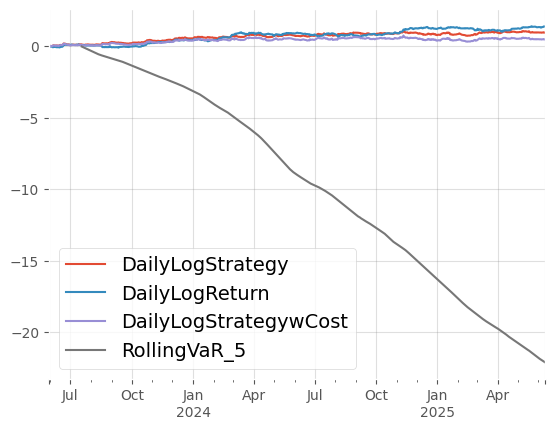

In [294]:
DailyStrategy.cumsum().plot()

In [295]:
DailyStrategy["DailySimpleStrategy"] = np.exp(DailyStrategy["DailyLogStrategy"]) - 1
DailyStrategy

,DailyLogStrategy,DailyLogReturn,DailyLogStrategywCost,RollingVaR_5,DailySimpleStrategy
2023-05-30,-0.002134,0.003164,-0.002434,NaN,-0.002132
2023-05-31,0.017117,-0.030651,0.016517,NaN,0.017265
2023-06-01,0.002442,-0.005679,0.001842,NaN,0.002445
2023-06-02,0.002211,0.013824,0.001811,NaN,0.002214
2023-06-03,-0.017715,-0.004857,-0.019115,NaN,-0.017559
...,...,...,...,...,...
2025-06-07,0.013257,0.011676,0.012857,-0.030583,0.013346
2025-06-08,0.001637,0.001637,0.001637,-0.030583,0.001638
2025-06-09,0.018670,0.041792,0.018270,-0.030583,0.018845
2025-06-10,-0.028075,-0.000136,-0.028875,-0.030583,-0.027685


In [296]:
from typing import Dict, Any
import pandas as pd
import numpy as np
from datetime import timedelta


class BacktestReport:
    def __init__(self, strategy_df: pd.DataFrame, strategy_col: str = "DailySimpleStrategy"):
        self.df = strategy_df.copy()
        self.strategy_returns = self.df[strategy_col].fillna(0)

        self.start_date = self.df.index.min()
        self.end_date = self.df.index.max()
        self.duration = self.end_date - self.start_date

        self.equity_curve = np.exp(self.strategy_returns.cumsum())
        self.final_equity = self.equity_curve.iloc[-1]
        self.equity_peak = self.equity_curve.cummax().max()
        self.return_pct = (self.final_equity - 1) * 100

    def compute_metrics(self) -> Dict[str, Any]:
        return {
            "Start": self.start_date,
            "End": self.end_date,
            "Duration": self.duration,
            "Equity Final [$]": self.final_equity,
            "Equity Peak [$]": self.equity_peak,
            "Return [%]": self.return_pct,
            "Return (Ann.) [%]": self._annualized_return() * 100,
            "Volatility (Ann.) [%]": self._annualized_volatility() * 100,
            "Sharpe Ratio": self._sharpe_ratio(),
            "Sortino Ratio": self._sortino_ratio(),
            "Calmar Ratio": self._calmar_ratio(),
            "Max. Drawdown [%]": self._max_drawdown()[0] * 100,
            "Avg. Drawdown [%]": self._average_drawdown()[0] * 100,
            "Max. Drawdown Duration": self._max_drawdown()[1],
            "Avg. Drawdown Duration": self._average_drawdown()[1],
        }

    def _annualized_return(self) -> float:
        return np.exp(self.strategy_returns.mean() * 252) - 1

    def _annualized_volatility(self) -> float:
        return self.strategy_returns.std(ddof=0) * np.sqrt(252)

    def _sharpe_ratio(self, risk_free_rate: float = 0.0) -> float:
        excess = self.strategy_returns - (risk_free_rate / 252)
        std = excess.std(ddof=0)
        return excess.mean() / std * np.sqrt(252) if std > 0 else np.nan

    def _sortino_ratio(self) -> float:
        downside = self.strategy_returns[self.strategy_returns < 0]
        dd_std = downside.std(ddof=0)
        return self._annualized_return() / (dd_std * np.sqrt(252)) if dd_std > 0 else np.nan

    def _calmar_ratio(self) -> float:
        max_dd, _ = self._max_drawdown()
        return self._annualized_return() / abs(max_dd) if max_dd != 0 else np.nan

    def _max_drawdown(self) -> (float, timedelta):
        peak = self.equity_curve.cummax()
        drawdown = (self.equity_curve - peak) / peak
        max_dd = drawdown.min()
        end = drawdown.idxmin()
        start = peak[:end][peak[:end] == peak[:end].max()].last_valid_index()
        duration = end - start if start and end else timedelta(0)
        return max_dd, duration

    def _average_drawdown(self) -> (float, timedelta):
        peak = self.equity_curve.cummax()
        drawdowns = (self.equity_curve - peak) / peak
        in_drawdown = drawdowns < 0

        dd_periods = []
        current = []

        for t, flag in zip(drawdowns.index, in_drawdown):
            if flag:
                current.append(t)
            elif current:
                dd_periods.append(current)
                current = []

        if not dd_periods:
            return 0.0, timedelta(0)

        dd_vals = [drawdowns.loc[p].min() for p in dd_periods]
        dd_durations = [p[-1] - p[0] for p in dd_periods]

        return np.mean(dd_vals), np.mean(dd_durations)

In [297]:
report = BacktestReport(DailyStrategy[["DailySimpleStrategy"]])
metrics = report.compute_metrics()
print(pd.Series(metrics))

Start                            2023-05-30 00:00:00
End                              2025-06-11 00:00:00
Duration                           743 days 00:00:00
Equity Final [$]                            3.168909
Equity Peak [$]                             3.526017
Return [%]                                216.890865
Return (Ann.) [%]                          47.796099
Volatility (Ann.) [%]                       37.52961
Sharpe Ratio                                1.040947
Sortino Ratio                               1.991489
Calmar Ratio                                 1.66681
Max. Drawdown [%]                           -28.6752
Avg. Drawdown [%]                          -6.309529
Max. Drawdown Duration               0 days 00:00:00
Avg. Drawdown Duration    20 days 03:52:15.483870967
dtype: object


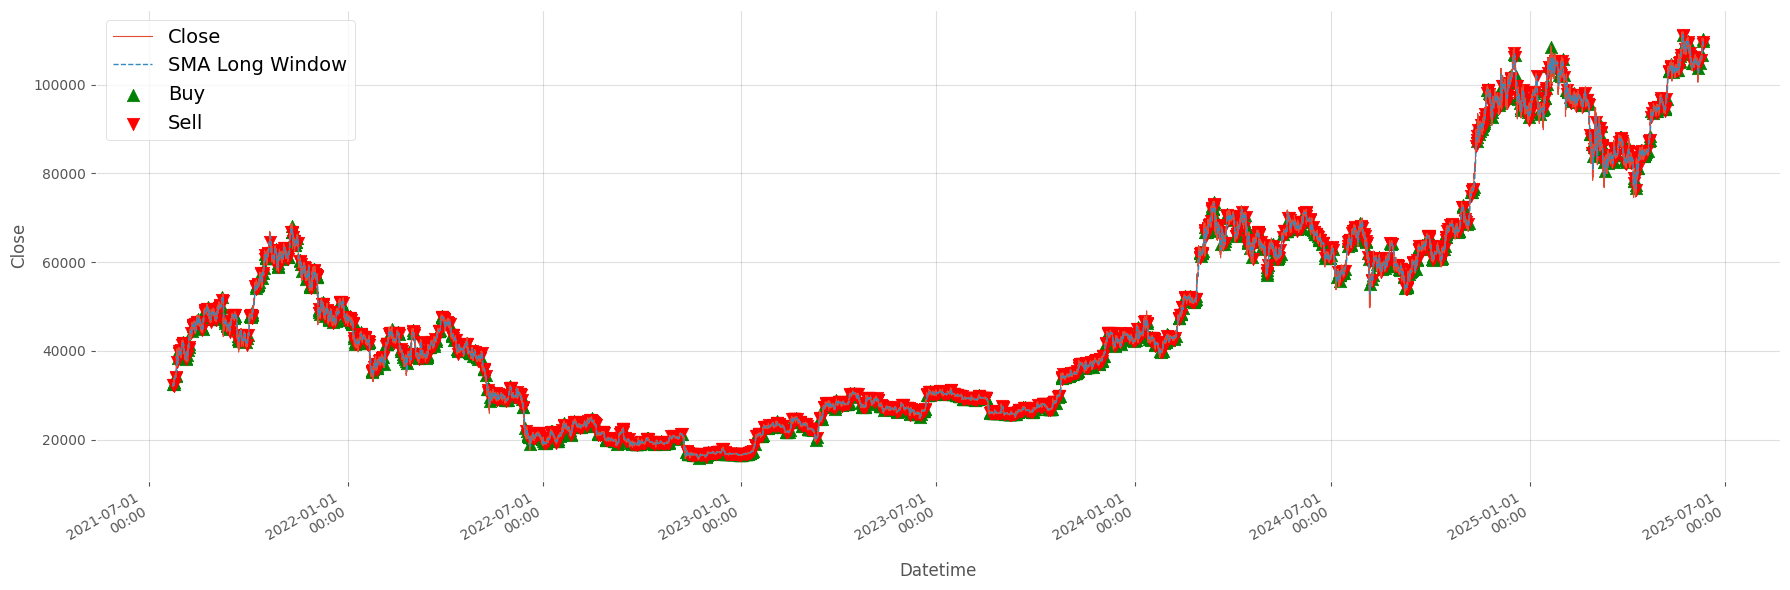

In [298]:
# select back test horizon
PriceDF = df_5min[1005000:]
PriceDF
# PriceDF.to_excel("price_data.xlsx", index=False)

SMACrossoverSignal(PriceDF, ShortWindow, LongWindow)
SignalDF = SMACrossoverSignal(PriceDF, ShortWindow, LongWindow)

SMACrossoverStrategyLongShort(SignalDF)
TradingStrategy = SMACrossoverStrategyLongShort(SignalDF)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(18, 6))

# Price line
ax.plot(TradingStrategy.index,
        TradingStrategy['Close'],
        linewidth=0.8,
        label='Close')

# Long SMA line
ax.plot(TradingStrategy.index,
        TradingStrategy['SMALongWindow'],
        linestyle='--', linewidth=1.0, label='SMA Long Window')

# Buy signals
buys = TradingStrategy.loc[TradingStrategy.Action >= 1.0]
ax.scatter(buys.index, buys['Close'],
           marker='^', color='green', s=80, label='Buy')

# Sell signals
sells = TradingStrategy.loc[TradingStrategy.Action <= -1.0]
ax.scatter(sells.index, sells['Close'],
           marker='v', color='red', s=80, label='Sell')

# Format x-axis
ax.set_xlabel('Datetime')
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
fig.autofmt_xdate()

ax.set_ylabel('Close')
ax.legend()
plt.tight_layout()
plt.show()

In [299]:
TradingStrategy

,Action,Open,High,Low,Close,SMAShortWindow,SMALongWindow,SMADiff,LongDiff,LongDiffSMA,Positions,Returns,Strategy,Strategy_w_cost
Datetime,,,,,,,,,,,,,,
2021-07-22 16:35:00,0.0,31934.46,32153.25,31917.96,32117.40,31908.568,31985.14510,-76.57710,2.78135,2.635075,0.0,0.000000,0.000000,0.000000
2021-07-22 16:40:00,0.0,32093.46,32217.98,32062.28,32165.99,31971.440,31987.92645,-16.48645,2.78135,2.635075,0.0,0.001512,0.000000,0.000000
2021-07-22 16:45:00,0.0,32165.59,32165.62,32069.86,32095.94,32025.866,31989.95550,35.91050,2.02905,2.635075,0.0,-0.002180,-0.000000,0.000000
2021-07-22 16:50:00,0.0,32087.44,32131.22,32077.69,32095.04,32084.050,31992.34750,91.70250,2.39200,2.635075,0.0,-0.000028,-0.000000,0.000000
2021-07-22 16:55:00,0.0,32096.66,32216.16,32093.34,32213.30,32137.534,31994.95765,142.57635,2.61015,2.635075,0.0,0.003678,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-11 00:25:00,0.0,109865.00,109955.00,109841.00,109897.00,109980.200,109416.37000,563.83000,3.28500,3.667500,1.0,0.000291,0.000291,0.000291
2025-06-11 00:30:00,0.0,109859.00,109874.00,109845.00,109872.00,109927.400,109419.18500,508.21500,2.81500,3.593500,1.0,-0.000228,-0.000228,-0.000228
2025-06-11 00:35:00,0.0,109950.00,110068.00,109930.00,109986.00,109924.000,109422.78500,501.21500,3.60000,3.575500,1.0,0.001037,0.001037,0.001037


In [300]:
Portfolio_strat = pd.DataFrame(index = TradingStrategy.index)

fee = 0.0002 # 2 bps
capital = 100000

Portfolio_strat["CashBalance"] = capital
Portfolio_strat = TradingStrategy[['Action','Open', 'High', 'Low', 'Close', 'Positions']]
Portfolio_strat["CoinHeld"] = 0
Portfolio_strat["Fee"] = 0
Portfolio_strat["PortfolioValue"] = Portfolio_strat["cash_balance"] + Portfolio_strat["CoinHeld"] * Portfolio_strat['Close']

Portfolio_strat["fee"][0] = np.where(Portfolio_strat["BUY_or_SELL"][0] != 0, \
                                     np.abs(Portfolio_strat['BUY_or_SELL'][0]) * fee,\
                                     0)

Portfolio_strat["shares_held"][0] = np.where(Portfolio_strat["BUY_or_SELL"][0] != 0, \
                                             Portfolio_strat['BUY_or_SELL'][0]\
                                             *\
                                             np.floor(\
                                                      (Portfolio_strat['cash_balance'][0] - Portfolio_strat["fee"][0]) / \
                                                      Portfolio_strat['Price'][0]),
                                             0)
Portfolio_strat['cash_balance'][0] += \
    - Portfolio_strat["fee"][0] - Portfolio_strat['shares_held'][0] * \
    Portfolio_strat['Price'][0]

Portfolio_strat['portfolio_value'][0] = \
    Portfolio_strat['cash_balance'][0] + \
    Portfolio_strat['shares_held'][0] * \
    Portfolio_strat['Price'][0]

Portfolio_strat["returns"] = np.log(Portfolio_strat["Price"]/Portfolio_strat["Price"].shift(1))
Portfolio_strat["returns"] = Portfolio_strat["returns"].fillna(0)
Portfolio_strat["strategy"] = Portfolio_strat["positions"].shift(1) * Portfolio_strat["returns"]
Portfolio_strat

KeyError: 'cash_balance'

In [ ]:
Portfolio_strat = pd.DataFrame(index = TradingStrategy.index)

fee = 0.0002 # 2 bps
capital = 100000

Portfolio_strat[["CashBalanceStart", "CashBalanceEnd","PositionValueStart", "PositionValueEnd"]] = 0
Portfolio_strat["CashBalanceStart"][0] = capital
Portfolio_strat[['Action','Open', 'High', 'Low', 'Close', 'Positions']] = TradingStrategy[['Action','Open', 'High', 'Low', 'Close', 'Positions']]
Portfolio_strat["CoinHeld"] = 0
Portfolio_strat["Fee"] = 0

if Portfolio_strat["Action"] == 0,
    Portfolio_strat["CoindHeld"] = Portfolio_strat["CoindHeld"].shift(1)
elif abs(Portfolio_strat["Action"]) == 1:
    Portfolio_strat["Fee"] =  Portfolio_strat["CashBalanceStart"]*fee*abs(Portfolio_strat["Action"])
    Portfolio_strat["CoindHeld"] = (Portfolio_strat["CashBalanceStart"]-Portfolio_strat["Fee"])/Portfolio_strat["Open"]*Portfolio_strat['Action']
    Portfolio_strat["CashBalanceEnd"] = Portfolio_strat["CashBalanceStart"] - Portfolio_strat["CoindHeld"]*Portfolio_strat["Open"] - Portfolio_strat["Fee"]   
    Portfolio_strat["PositionValueStart"] = Portfolio_strat["CashBalanceStart"] + Portfolio_strat["CoindHeld"].shift(1)*Portfolio_strat["Close"].shift(1)
    Portfolio_strat["PositionValueEnd"] = Portfolio_strat["CashBalanceEnd"] + Portfolio_strat["CoindHeld"]*Portfolio_strat["Close"]
else:
    trade_fee =  Portfolio_strat["CoindHeld"]*Portfolio_strat["Open"]*fee
    Portfolio_strat["CoindHeld"]




    



SyntaxError: invalid syntax (4176384512.py, line 12)

In [ ]:
Portfolio_strat

,Action,Open,High,Low,Close,Positions,CoinHeld,Fee
Datetime,,,,,,,,
2021-07-22 16:35:00,0.0,31934.46,32153.25,31917.96,32117.40,0.0,0,0
2021-07-22 16:40:00,0.0,32093.46,32217.98,32062.28,32165.99,0.0,0,0
2021-07-22 16:45:00,0.0,32165.59,32165.62,32069.86,32095.94,0.0,0,0
2021-07-22 16:50:00,0.0,32087.44,32131.22,32077.69,32095.04,0.0,0,0
2021-07-22 16:55:00,0.0,32096.66,32216.16,32093.34,32213.30,0.0,0,0
...,...,...,...,...,...,...,...,...
2025-06-04 00:25:00,0.0,105492.00,105492.00,105370.00,105370.00,1.0,0,0
2025-06-04 00:30:00,0.0,105356.00,105383.00,105314.00,105374.00,1.0,0,0
2025-06-04 00:35:00,0.0,105368.00,105387.00,105301.00,105301.00,1.0,0,0


In [ ]:
import pandas as pd
import numpy as np

fee = 0.0002  # 2 bps
capital = 100000

Portfolio_strat = pd.DataFrame(index=TradingStrategy.index)
Portfolio_strat[["CashBalanceStart", "CashBalanceEnd", "PositionValueStart", "PositionValueEnd"]] = 0.0
Portfolio_strat["CashBalanceStart"].iloc[0] = capital

Portfolio_strat[["Action", "Open", "High", "Low", "Close", "Positions"]] = TradingStrategy[["Action", "Open", "High", "Low", "Close", "Positions"]]
Portfolio_strat["CoinHeld"] = 0.0
Portfolio_strat["Fee"] = 0.0

for t in range(1, len(Portfolio_strat)):
    prev_cash = Portfolio_strat["CashBalanceEnd"].iloc[t - 1]
    prev_coin = Portfolio_strat["CoinHeld"].iloc[t - 1]
    action = Portfolio_strat["Action"].iloc[t]
    open_price = Portfolio_strat["Open"].iloc[t]
    close_price = Portfolio_strat["Close"].iloc[t]

    Portfolio_strat["CashBalanceStart"].iloc[t] = prev_cash
    Portfolio_strat["PositionValueStart"].iloc[t] = prev_cash + prev_coin * close_price

    if action == 0:
        Portfolio_strat["CoinHeld"].iloc[t] = prev_coin
        Portfolio_strat["CashBalanceEnd"].iloc[t] = prev_cash
        Portfolio_strat["PositionValueEnd"].iloc[t] = prev_cash + prev_coin * close_price

    elif abs(action) == 1:
        coin = (prev_cash * action) / open_price
        fee_amt = abs(prev_cash * fee)
        cash_end = prev_cash - abs(coin * open_price) - fee_amt

        Portfolio_strat["Fee"].iloc[t] = fee_amt
        Portfolio_strat["CoinHeld"].iloc[t] = coin
        Portfolio_strat["CashBalanceEnd"].iloc[t] = cash_end
        Portfolio_strat["PositionValueEnd"].iloc[t] = cash_end + coin * close_price

    elif abs(action) == 2:
        close_amt = prev_coin * open_price
        fee_close = abs(close_amt * fee)

        cash_after_close = prev_cash + close_amt - fee_close

        coin = (cash_after_close * np.sign(action)) / open_price
        fee_open = abs(cash_after_close * fee)
        cash_end = cash_after_close - abs(coin * open_price) - fee_open

        Portfolio_strat["Fee"].iloc[t] = fee_close + fee_open
        Portfolio_strat["CoinHeld"].iloc[t] = coin
        Portfolio_strat["CashBalanceEnd"].iloc[t] = cash_end
        Portfolio_strat["PositionValueEnd"].iloc[t] = cash_end + coin * close_price

    else:
        raise ValueError(f"Invalid action at t={t}: {action}")

In [ ]:
Portfolio_strat

,CashBalanceStart,CashBalanceEnd,PositionValueStart,PositionValueEnd,Action,Open,High,Low,Close,Positions,CoinHeld,Fee
Datetime,,,,,,,,,,,,
2021-07-22 16:35:00,100000.0,0.0,0.0,0.0,0.0,31934.46,32153.25,31917.96,32117.40,0.0,0.0,0.0
2021-07-22 16:40:00,0.0,0.0,0.0,0.0,0.0,32093.46,32217.98,32062.28,32165.99,0.0,0.0,0.0
2021-07-22 16:45:00,0.0,0.0,0.0,0.0,0.0,32165.59,32165.62,32069.86,32095.94,0.0,0.0,0.0
2021-07-22 16:50:00,0.0,0.0,0.0,0.0,0.0,32087.44,32131.22,32077.69,32095.04,0.0,0.0,0.0
2021-07-22 16:55:00,0.0,0.0,0.0,0.0,0.0,32096.66,32216.16,32093.34,32213.30,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-04 00:25:00,0.0,0.0,0.0,0.0,0.0,105492.00,105492.00,105370.00,105370.00,1.0,0.0,0.0
2025-06-04 00:30:00,0.0,0.0,0.0,0.0,0.0,105356.00,105383.00,105314.00,105374.00,1.0,0.0,0.0
2025-06-04 00:35:00,0.0,0.0,0.0,0.0,0.0,105368.00,105387.00,105301.00,105301.00,1.0,0.0,0.0


In [ ]:
import pandas as pd
import numpy as np

fee = 0.0002  # 2 bps
capital = 100000

Portfolio_strat = pd.DataFrame(index=TradingStrategy.index)
Portfolio_strat[["CashBalanceStart", "CashBalanceEnd", "PositionValueStart", "PositionValueEnd"]] = 0.0
Portfolio_strat["CashBalanceStart"].iloc[0] = capital

Portfolio_strat[["Action", "Open", "High", "Low", "Close", "Positions"]] = TradingStrategy[["Action", "Open", "High", "Low", "Close", "Positions"]]
Portfolio_strat["CoinHeld"] = 0.0
Portfolio_strat["Fee"] = 0.0

In [ ]:
Portfolio_strat

,CashBalanceStart,CashBalanceEnd,PositionValueStart,PositionValueEnd,Action,Open,High,Low,Close,Positions,CoinHeld,Fee
Datetime,,,,,,,,,,,,
2021-07-22 16:35:00,100000.0,0.0,0.0,0.0,0.0,31934.46,32153.25,31917.96,32117.40,0.0,0.0,0.0
2021-07-22 16:40:00,0.0,0.0,0.0,0.0,0.0,32093.46,32217.98,32062.28,32165.99,0.0,0.0,0.0
2021-07-22 16:45:00,0.0,0.0,0.0,0.0,0.0,32165.59,32165.62,32069.86,32095.94,0.0,0.0,0.0
2021-07-22 16:50:00,0.0,0.0,0.0,0.0,0.0,32087.44,32131.22,32077.69,32095.04,0.0,0.0,0.0
2021-07-22 16:55:00,0.0,0.0,0.0,0.0,0.0,32096.66,32216.16,32093.34,32213.30,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-04 00:25:00,0.0,0.0,0.0,0.0,0.0,105492.00,105492.00,105370.00,105370.00,1.0,0.0,0.0
2025-06-04 00:30:00,0.0,0.0,0.0,0.0,0.0,105356.00,105383.00,105314.00,105374.00,1.0,0.0,0.0
2025-06-04 00:35:00,0.0,0.0,0.0,0.0,0.0,105368.00,105387.00,105301.00,105301.00,1.0,0.0,0.0


In [ ]:
import pandas as pd
import numpy as np

def compute_portfolio(TradingStrategy, initial_capital=100000, fee=0.0002):
    Portfolio_strat = pd.DataFrame(index=TradingStrategy.index)

    # Copy required columns
    Portfolio_strat[["Action", "Open", "High", "Low", "Close", "Positions"]] = TradingStrategy[["Action", "Open", "High", "Low", "Close", "Positions"]]

    # Initialize portfolio metrics
    Portfolio_strat[["CashBalanceStart", "CashBalanceEnd", "PositionValueStart", "PositionValueEnd"]] = 0.0
    Portfolio_strat["CoinHeld"] = 0.0
    Portfolio_strat["Fee"] = 0.0

    # Set initial capital
    Portfolio_strat["CashBalanceStart"].iloc[0] = initial_capital
    Portfolio_strat["CashBalanceEnd"].iloc[0] = initial_capital
    Portfolio_strat["PositionValueStart"].iloc[0] = initial_capital
    Portfolio_strat["PositionValueEnd"].iloc[0] = initial_capital

    for t in range(1, len(Portfolio_strat)):
        prev_cash = Portfolio_strat["CashBalanceEnd"].iloc[t - 1]
        prev_coin = Portfolio_strat["CoinHeld"].iloc[t - 1]
        action = Portfolio_strat["Action"].iloc[t]
        open_price = Portfolio_strat["Open"].iloc[t]
        close_price = Portfolio_strat["Close"].iloc[t]

        # Start of period
        Portfolio_strat.loc[Portfolio_strat.index[t], "CashBalanceStart"] = prev_cash
        Portfolio_strat.loc[Portfolio_strat.index[t], "PositionValueStart"] = prev_cash + prev_coin * close_price

        if action == 0:
            # Hold
            Portfolio_strat.loc[Portfolio_strat.index[t], "CoinHeld"] = prev_coin
            Portfolio_strat.loc[Portfolio_strat.index[t], "CashBalanceEnd"] = prev_cash
            Portfolio_strat.loc[Portfolio_strat.index[t], "PositionValueEnd"] = prev_cash + prev_coin * close_price

        elif abs(action) == 1:
            # Enter new position
            coin = (prev_cash * np.sign(action)) / open_price
            fee_amt = abs(prev_cash * fee)
            cash_end = prev_cash - abs(coin * open_price) - fee_amt

            Portfolio_strat.loc[Portfolio_strat.index[t], "Fee"] = fee_amt
            Portfolio_strat.loc[Portfolio_strat.index[t], "CoinHeld"] = coin
            Portfolio_strat.loc[Portfolio_strat.index[t], "CashBalanceEnd"] = cash_end
            Portfolio_strat.loc[Portfolio_strat.index[t], "PositionValueEnd"] = cash_end + coin * close_price

        elif abs(action) == 2:
            # Close previous position, then flip
            close_amt = prev_coin * open_price
            fee_close = abs(close_amt * fee)
            cash_after_close = prev_cash + close_amt - fee_close

            coin = (cash_after_close * np.sign(action)) / open_price
            fee_open = abs(cash_after_close * fee)
            cash_end = cash_after_close - abs(coin * open_price) - fee_open

            Portfolio_strat.loc[Portfolio_strat.index[t], "Fee"] = fee_close + fee_open
            Portfolio_strat.loc[Portfolio_strat.index[t], "CoinHeld"] = coin
            Portfolio_strat.loc[Portfolio_strat.index[t], "CashBalanceEnd"] = cash_end
            Portfolio_strat.loc[Portfolio_strat.index[t], "PositionValueEnd"] = cash_end + coin * close_price

        else:
            raise ValueError(f"Invalid action value at index {Portfolio_strat.index[t]}: {action}")

    return Portfolio_strat

In [ ]:
Portfolio_strat = compute_portfolio(TradingStrategy, initial_capital=100000, fee=0.0000)

<Axes: xlabel='Datetime'>

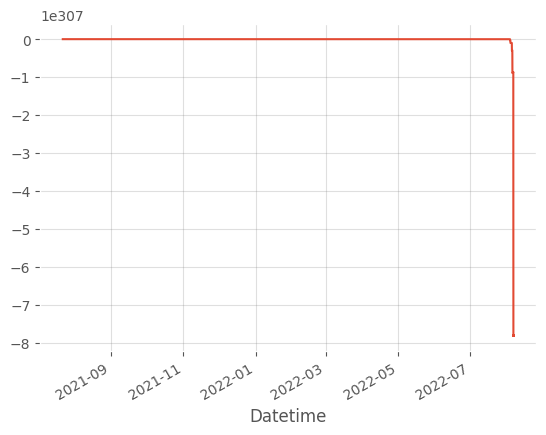

In [ ]:
Portfolio_strat["PositionValueEnd"].plot()